In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from pyspark.ml import *
from pyspark.ml.classification import *
from pyspark.ml.feature import *
from pyspark.ml.tuning import *
from pyspark.ml.evaluation import *
from pyspark.sql.types import DoubleType
from sklearn.metrics import classification_report
from time import time
from pyspark import SparkContext
from pyspark.sql import SQLContext, Row
import matplotlib.pyplot as plt


In [2]:
sc = SparkContext()
sqlContext = SQLContext(sc)

In [8]:
rdd1 = sc.textFile("./amazon_cells_labelled.txt")
print(rdd1.collect())

['So there is no way for me to plug it in here in the US unless I go by a converter.\t0', 'Good case, Excellent value.\t1', 'Great for the jawbone.\t1', 'Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!\t0', 'The mic is great.\t1', 'I have to jiggle the plug to get it to line up right to get decent volume.\t0', 'If you have several dozen or several hundred contacts, then imagine the fun of sending each of them one by one.\t0', 'If you are Razr owner...you must have this!\t1', 'Needless to say, I wasted my money.\t0', 'What a waste of money and time!.\t0', 'And the sound quality is great.\t1', 'He was very impressed when going from the original battery to the extended battery.\t1', 'If the two were seperated by a mere 5+ ft I started to notice excessive static and garbled sound from the headset.\t0', 'Very good quality though\t1', 'The design is very odd, as the ear "clip" is not very comfortable at all.\t0', 'Highly recommend for any one who has a blue to

In [9]:
rdd2 = rdd1.map(lambda x: x.split("\t"))
#print(rdd2.collect())

In [10]:
rdd3 = rdd2.map(lambda x: Row(review=x[0], label=x[1]))
print(rdd3.collect())

[Row(label='0', review='So there is no way for me to plug it in here in the US unless I go by a converter.'), Row(label='1', review='Good case, Excellent value.'), Row(label='1', review='Great for the jawbone.'), Row(label='0', review='Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!'), Row(label='1', review='The mic is great.'), Row(label='0', review='I have to jiggle the plug to get it to line up right to get decent volume.'), Row(label='0', review='If you have several dozen or several hundred contacts, then imagine the fun of sending each of them one by one.'), Row(label='1', review='If you are Razr owner...you must have this!'), Row(label='0', review='Needless to say, I wasted my money.'), Row(label='0', review='What a waste of money and time!.'), Row(label='1', review='And the sound quality is great.'), Row(label='1', review='He was very impressed when going from the original battery to the extended battery.'), Row(label='0', review='If the two were 

In [6]:
df = sqlContext.createDataFrame(rdd3)
df.registerTempTable("df")
df = df.withColumn("label", df.label.cast(DoubleType()))
df.show(10)

+-----+--------------------+
|label|              review|
+-----+--------------------+
|  0.0|So there is no wa...|
|  1.0|Good case, Excell...|
|  1.0|Great for the jaw...|
|  0.0|Tied to charger f...|
|  1.0|   The mic is great.|
|  0.0|I have to jiggle ...|
|  0.0|If you have sever...|
|  1.0|If you are Razr o...|
|  0.0|Needless to say, ...|
|  0.0|What a waste of m...|
+-----+--------------------+
only showing top 10 rows



In [18]:
indexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(df)
indexed = indexer.transform(df)
indexed.show(10)

+-----+--------------------+------------+
|label|              review|indexedLabel|
+-----+--------------------+------------+
|  0.0|So there is no wa...|         0.0|
|  1.0|Good case, Excell...|         1.0|
|  1.0|Great for the jaw...|         1.0|
|  0.0|Tied to charger f...|         0.0|
|  1.0|   The mic is great.|         1.0|
|  0.0|I have to jiggle ...|         0.0|
|  0.0|If you have sever...|         0.0|
|  1.0|If you are Razr o...|         1.0|
|  0.0|Needless to say, ...|         0.0|
|  0.0|What a waste of m...|         0.0|
+-----+--------------------+------------+
only showing top 10 rows



In [19]:
tokenizer = RegexTokenizer(inputCol="review", outputCol="words", pattern="\W")
df_tokenized = tokenizer.transform(df)
df_tokenized.show(10)

+-----+--------------------+--------------------+
|label|              review|               words|
+-----+--------------------+--------------------+
|  0.0|So there is no wa...|[so, there, is, n...|
|  1.0|Good case, Excell...|[good, case, exce...|
|  1.0|Great for the jaw...|[great, for, the,...|
|  0.0|Tied to charger f...|[tied, to, charge...|
|  1.0|   The mic is great.|[the, mic, is, gr...|
|  0.0|I have to jiggle ...|[i, have, to, jig...|
|  0.0|If you have sever...|[if, you, have, s...|
|  1.0|If you are Razr o...|[if, you, are, ra...|
|  0.0|Needless to say, ...|[needless, to, sa...|
|  0.0|What a waste of m...|[what, a, waste, ...|
+-----+--------------------+--------------------+
only showing top 10 rows



In [20]:
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
df_cleaned = remover.transform(df_tokenized)
df_cleaned.show(10)

+-----+--------------------+--------------------+--------------------+
|label|              review|               words|            filtered|
+-----+--------------------+--------------------+--------------------+
|  0.0|So there is no wa...|[so, there, is, n...|[way, plug, us, u...|
|  1.0|Good case, Excell...|[good, case, exce...|[good, case, exce...|
|  1.0|Great for the jaw...|[great, for, the,...|    [great, jawbone]|
|  0.0|Tied to charger f...|[tied, to, charge...|[tied, charger, c...|
|  1.0|   The mic is great.|[the, mic, is, gr...|        [mic, great]|
|  0.0|I have to jiggle ...|[i, have, to, jig...|[jiggle, plug, ge...|
|  0.0|If you have sever...|[if, you, have, s...|[several, dozen, ...|
|  1.0|If you are Razr o...|[if, you, are, ra...| [razr, owner, must]|
|  0.0|Needless to say, ...|[needless, to, sa...|[needless, say, w...|
|  0.0|What a waste of m...|[what, a, waste, ...|[waste, money, time]|
+-----+--------------------+--------------------+--------------------+
only s

Term frequency-inverse document frequency (TF-IDF) is a feature vectorization method widely used in text mining to reflect the importance of a term to a document 

In [21]:
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures")
df_TF = hashingTF.transform(df_cleaned)
df_TF.show(10)

+-----+--------------------+--------------------+--------------------+--------------------+
|label|              review|               words|            filtered|         rawFeatures|
+-----+--------------------+--------------------+--------------------+--------------------+
|  0.0|So there is no wa...|[so, there, is, n...|[way, plug, us, u...|(262144,[21872,52...|
|  1.0|Good case, Excell...|[good, case, exce...|[good, case, exce...|(262144,[113432,1...|
|  1.0|Great for the jaw...|[great, for, the,...|    [great, jawbone]|(262144,[138356,1...|
|  0.0|Tied to charger f...|[tied, to, charge...|[tied, charger, c...|(262144,[22836,32...|
|  1.0|   The mic is great.|[the, mic, is, gr...|        [mic, great]|(262144,[80228,13...|
|  0.0|I have to jiggle ...|[i, have, to, jig...|[jiggle, plug, ge...|(262144,[99895,11...|
|  0.0|If you have sever...|[if, you, have, s...|[several, dozen, ...|(262144,[8443,829...|
|  1.0|If you are Razr o...|[if, you, are, ra...| [razr, owner, must]|(262144,[1

In [22]:
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(df_TF)
df_idf = idfModel.transform(df_TF)
df_idf.show(10)

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|label|              review|               words|            filtered|         rawFeatures|            features|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|  0.0|So there is no wa...|[so, there, is, n...|[way, plug, us, u...|(262144,[21872,52...|(262144,[21872,52...|
|  1.0|Good case, Excell...|[good, case, exce...|[good, case, exce...|(262144,[113432,1...|(262144,[113432,1...|
|  1.0|Great for the jaw...|[great, for, the,...|    [great, jawbone]|(262144,[138356,1...|(262144,[138356,1...|
|  0.0|Tied to charger f...|[tied, to, charge...|[tied, charger, c...|(262144,[22836,32...|(262144,[22836,32...|
|  1.0|   The mic is great.|[the, mic, is, gr...|        [mic, great]|(262144,[80228,13...|(262144,[80228,13...|
|  0.0|I have to jiggle ...|[i, have, to, jig...|[jiggle, plug, ge...|(262144,[99895,11...|(2621

In [23]:
(train, test) = df.randomSplit([0.8, 0.2], seed=0)
print('Train')
print(train.show(10))
print('Test')
print(test.show(10))

Train
+-----+--------------------+
|label|              review|
+-----+--------------------+
|  0.0|   A Disappointment.|
|  0.0|A PIECE OF JUNK T...|
|  0.0|AFTER ARGUING WIT...|
|  0.0|     Absolutel junk.|
|  0.0|After 3 months, s...|
|  0.0|After a year the ...|
|  0.0|All I can do is w...|
|  0.0|All in all, I'd e...|
|  0.0|Also the area whe...|
|  0.0|Also, if your pho...|
+-----+--------------------+
only showing top 10 rows

None
Test
+-----+--------------------+
|label|              review|
+-----+--------------------+
|  0.0|1. long lasting b...|
|  0.0|A week later afte...|
|  0.0|       AMAZON SUCKS.|
|  0.0|        Bad Quality.|
|  0.0|Basically the ser...|
|  0.0|Big Disappointmen...|
|  0.0|But when I check ...|
|  0.0|Cant get the soft...|
|  0.0|      Disappointed!.|
|  0.0|Do Not Buy for D8...|
+-----+--------------------+
only showing top 10 rows

None


In [13]:
train = train.cache()
test = test.cache()
print('Sample number in the train set : {}'.format(train.count()))
print('Sample number in the test set : {}'.format(test.count()))
print('Train')
print(train.groupby('label').count().toPandas())
print('Test')
print(test.groupby('label').count().toPandas())

Sample number in the train set : 808
Sample number in the test set : 192
Train
   label  count
0    0.0    407
1    1.0    401
Test
   label  count
0    0.0     93
1    1.0     99


In [24]:
def grid_search(p1, p2, p3, p4):
    lr = LogisticRegression()
    pipeline = Pipeline(stages=[indexer, tokenizer, remover, hashingTF, idfModel, lr])

    # Create ParamGrid for Cross Validation
    param_grid = (ParamGridBuilder()
                  .addGrid(hashingTF.numFeatures, [p1])
                  .addGrid(lr.regParam, [p2])
                  .addGrid(lr.elasticNetParam, [p3])
                  .addGrid(lr.maxIter, [p4])
                  .build())
    evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction",
                                                  metricName="accuracy")
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=param_grid,
                              evaluator=evaluator,
                              numFolds=4)

    # Finding the best set of parameters.
    cv_model = crossval.fit(train)
    # average cross-validation accuracy metric/s on all folds
    average_score = cv_model.avgMetrics
    print ('average cross-validation accuracy = {}'.format(average_score[0]))
    return average_score[0]


In [25]:
score = 0.0
for p1 in [45000, 50000, 55000]:
    for p2 in [0.09, 0.10, 0.11]:
        for p3 in [0.09, 0.10, 0.11]:
            for p4 in [9, 10, 11]:
                t0 = time()
                print('Running with (numFeatures,regParam,elasticNetParam,maxIter)=({},{},{},{})'.format(p1, p2, p3, p4))
                average_score = grid_search(p1, p2, p3, p4)
                tt = time() - t0
                print("Classifier trained in {} seconds".format(round(tt, 3)))
                if average_score > score:
                    print('Best score')
                    params = (p1, p2, p3, p4)
                    score = average_score
                    best_time = tt
print('Best score is {} at params ={}. Time = {}'.format(score, params,best_time))


Running with (numFeatures,regParam,elasticNetParam,maxIter)=(45000,0.09,0.09,9)
average cross-validation accuracy = 0.8084261169851922
Classifier trained in 8.996 seconds
Best score
Running with (numFeatures,regParam,elasticNetParam,maxIter)=(45000,0.09,0.09,10)
average cross-validation accuracy = 0.8045606235848151
Classifier trained in 7.499 seconds
Running with (numFeatures,regParam,elasticNetParam,maxIter)=(45000,0.09,0.09,11)
average cross-validation accuracy = 0.8072911569644287
Classifier trained in 8.887 seconds
Running with (numFeatures,regParam,elasticNetParam,maxIter)=(45000,0.09,0.1,9)
average cross-validation accuracy = 0.8046416139816681
Classifier trained in 6.508 seconds
Running with (numFeatures,regParam,elasticNetParam,maxIter)=(45000,0.09,0.1,10)
average cross-validation accuracy = 0.8059663854730483
Classifier trained in 9.242 seconds
Running with (numFeatures,regParam,elasticNetParam,maxIter)=(45000,0.09,0.1,11)
average cross-validation accuracy = 0.804758656004449

average cross-validation accuracy = 0.8088215972034996
Classifier trained in 6.084 seconds
Running with (numFeatures,regParam,elasticNetParam,maxIter)=(50000,0.11,0.1,10)
average cross-validation accuracy = 0.8088215972034996
Classifier trained in 6.34 seconds
Running with (numFeatures,regParam,elasticNetParam,maxIter)=(50000,0.11,0.1,11)
average cross-validation accuracy = 0.8139308716984042
Classifier trained in 6.448 seconds
Running with (numFeatures,regParam,elasticNetParam,maxIter)=(50000,0.11,0.11,9)
average cross-validation accuracy = 0.8100293266720986
Classifier trained in 6.055 seconds
Running with (numFeatures,regParam,elasticNetParam,maxIter)=(50000,0.11,0.11,10)
average cross-validation accuracy = 0.810172948554851
Classifier trained in 6.949 seconds
Running with (numFeatures,regParam,elasticNetParam,maxIter)=(50000,0.11,0.11,11)
average cross-validation accuracy = 0.8087140269466756
Classifier trained in 7.749 seconds
Running with (numFeatures,regParam,elasticNetParam,max

In [26]:
def data_modeling(train, test, pipeline, paramGrid):
    evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction",
                                                  metricName="accuracy")
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=evaluator,
                              numFolds=4)

    cvModel = crossval.fit(train)

    prediction = cvModel.transform(test)
    average_score = cvModel.avgMetrics
#     print ('Average cross-validation accuracy = {}'.format(average_score[0]))
    evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction",
                                                  metricName="accuracy")
    accuracy_score = evaluator.evaluate(prediction)
#     print ('Accuracy in the test data = {}'.format(accuracy_score))

    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    f1_score = evaluator.evaluate(prediction)
#     print ('F1 score in the test data = {}'.format(f1_score))
    prediction_and_labels = prediction.select("label", "prediction")
    y_true = []
    y_pred = []
    for x in prediction_and_labels.collect():
        xx = list(x)
        try:
            tt = int(xx[1])
            pp = int(xx[0])
            y_true.append(tt)
            y_pred.append(pp)
        except:
            continue
    target_names = ['neg 0', 'pos 1']
    return classification_report(y_true, y_pred, target_names=target_names),accuracy_score


# trained by a logistic regression
lr = LogisticRegression()
# Build a pipeline
pipeline = Pipeline(stages=[indexer, tokenizer, remover, hashingTF, idfModel, lr])

paramGrid = (ParamGridBuilder()
             .addGrid(hashingTF.numFeatures, [params[0]])
             .addGrid(lr.regParam, [params[1]])
             .addGrid(lr.elasticNetParam, [params[2]])
             .addGrid(lr.maxIter, [params[3]])
             .build())
stats,accuracy = data_modeling(train, test, pipeline, paramGrid)


In [31]:
accuracy = float("%.3f"%accuracy)
print("Accuracy of the model is "+str(accuracy))
# print(best_time)

Accuracy of the model is 0.823


In [32]:
print(stats)

             precision    recall  f1-score   support

      neg 0       0.88      0.78      0.83       105
      pos 1       0.77      0.87      0.82        87

avg / total       0.83      0.82      0.82       192



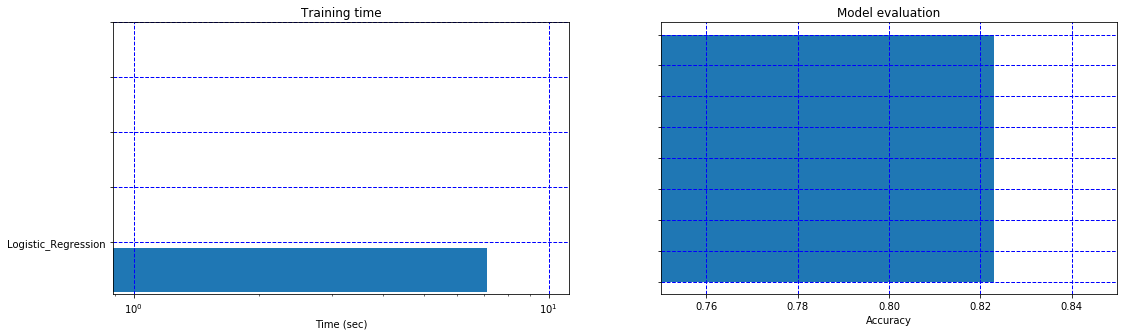

In [33]:
classifier_names = ['Logistic_Regression']
time = [best_time]
accuracy = [accuracy]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 5), facecolor='white')
ax[0].barh(np.arange(0, 1), time)
ax[0].set_yticks(np.arange(0.5, 5.5))
ax[0].set_yticklabels(classifier_names)
ax[0].grid(color='b', linestyle='--', linewidth=1)
ax[0].set_title('Training time')
ax[0].set_xlabel('Time (sec)')
ax[0].set_xscale('log')

ax[1].barh(range(0, len(classifier_names)), accuracy)
ax[1].set_xlim([0.75, 0.85])
ax[1].set_title('Model evaluation')
ax[1].set_xlabel('Accuracy')
ax[1].set_yticklabels([])
ax[1].grid(color='b', linestyle='--', linewidth=1)
plt.show()
